In [52]:
import pandas as pd
import warnings
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
warnings.filterwarnings('ignore')

house_df_org = pd.read_csv('./data/house-prices-advanced-regression-techniques/house_price.csv')
house_df = house_df_org.copy()
house_df.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [53]:
print(f'데이터 세트의 shape: {house_df.shape}')
print()
print(f'전체 피처의 type: \n{house_df.dtypes.value_counts()}')
isnull_series = house_df.isnull().sum()
print()
print(f'Null칼럼 수: \n{isnull_series[isnull_series>0].sort_values(ascending=False)}')

데이터 세트의 shape: (1460, 81)

전체 피처의 type: 
object     43
int64      35
float64     3
dtype: int64

Null칼럼 수: 
PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtExposure      38
BsmtFinType2      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64


# 타깃 분포도 확인

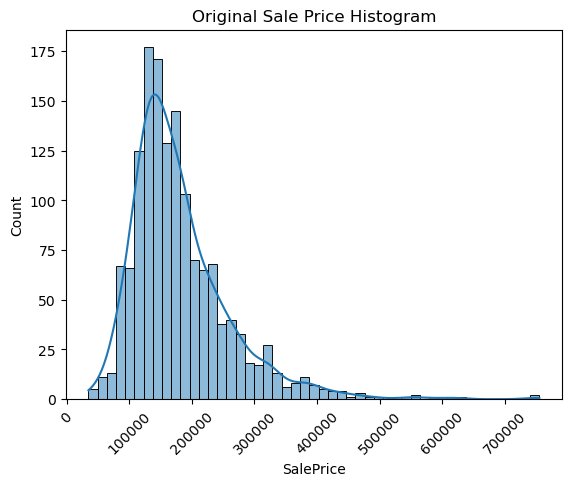

In [54]:
plt.title('Original Sale Price Histogram')
plt.xticks(rotation=45)
sns.histplot(house_df['SalePrice'], kde=True)
plt.show()

- target인 Sale price의 분포도 확인 결과, 정규분포가 아닌 오른쪽 꼬리가 긴 형태이다.
- 이를 정규분포 형태로 변환하기 위해 로그 변환을 적용하겠다.

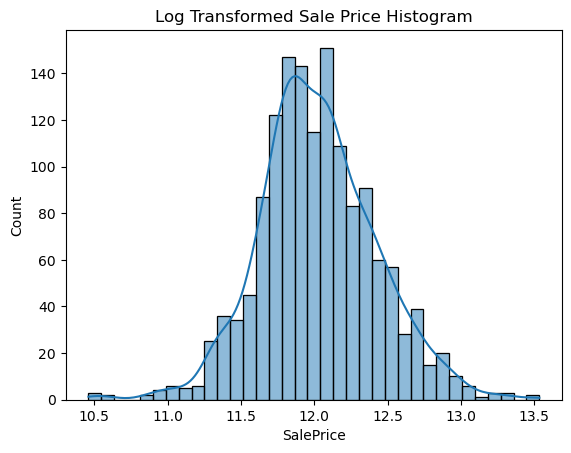

In [55]:
plt.title('Log Transformed Sale Price Histogram')
log_SalePrice = np.log1p(house_df['SalePrice'])
sns.histplot(log_SalePrice,kde=True)
plt.show()

- 로그변환 후, 정규분포 형태로 target값이 변형됨.
- 로그변환한 target값을 dataframe에 반영하겠다.

In [56]:
original_SalePrice = house_df['SalePrice']
house_df['SalePrice'] = np.log1p(original_SalePrice)

# Null값 drop & 대체

In [57]:
drop_col = ['PoolQC','MiscFeature','Alley','Fence','FireplaceQu']
house_df.drop(drop_col, axis=1, inplace=True)

# 나머지 null값은 평균값으로 대체
house_df.fillna(house_df.mean(), inplace=True)

In [58]:
# Nill값이 있는 피처명과 타입을 추출
null_column_count = house_df.isnull().sum()[house_df.isnull().sum()>0]
print(f' Null 피처의 type: \n\n{house_df.dtypes[null_column_count.index]}')

 Null 피처의 type: 

MasVnrType      object
BsmtQual        object
BsmtCond        object
BsmtExposure    object
BsmtFinType1    object
BsmtFinType2    object
Electrical      object
GarageType      object
GarageFinish    object
GarageQual      object
GarageCond      object
dtype: object


- 문자형 피처 제외하고는 Null값이 없는 것을 확인.
- 문자형 피처 -> 원핫 인코딩으로 변환하겠음.

In [59]:
print(f'get_dummies() 수행 전 데이터: {house_df.shape}')
house_df_ohe = pd.get_dummies(house_df)
print(f'get_dummies() 수행 후 데이터: {house_df_ohe.shape}')


get_dummies() 수행 전 데이터: (1460, 76)
get_dummies() 수행 후 데이터: (1460, 272)


In [60]:
null_column_count = house_df_ohe.isnull().sum()[house_df_ohe.isnull().sum()>0]
null_column_count  # null값이 더 이상 없는 것을 확인.

Series([], dtype: int64)

# 선형회귀

In [61]:
# 평가 함수 생성

def get_rmse(model):
    pred = model.predict(X_test)
    mse = mean_squared_error(y_test, pred)
    rmse = np.sqrt(mse)
    print(model.__class__.__name__, ' 로그변환된 RMSE: ', np.round(rmse,3))
    return rmse

In [62]:
def get_rmses(models):
    rmses=[]
    for model in models:
        rmse = get_rmse(model)
        rmses.append(rmse)

    return rmses

In [63]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice', axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

# 선형회귀
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)

ridge_reg = Ridge()
ridge_reg.fit(X_train, y_train)

lasso_reg = Lasso()
lasso_reg.fit(X_train, y_train)

models = [lr_reg, ridge_reg, lasso_reg]

get_rmses(models)

LinearRegression  로그변환된 RMSE:  0.133
Ridge  로그변환된 RMSE:  0.129
Lasso  로그변환된 RMSE:  0.177


[0.13310814108420002, 0.12882090738687857, 0.17688509722693233]

- 성능: Ridge > 일반선형 > RMSE

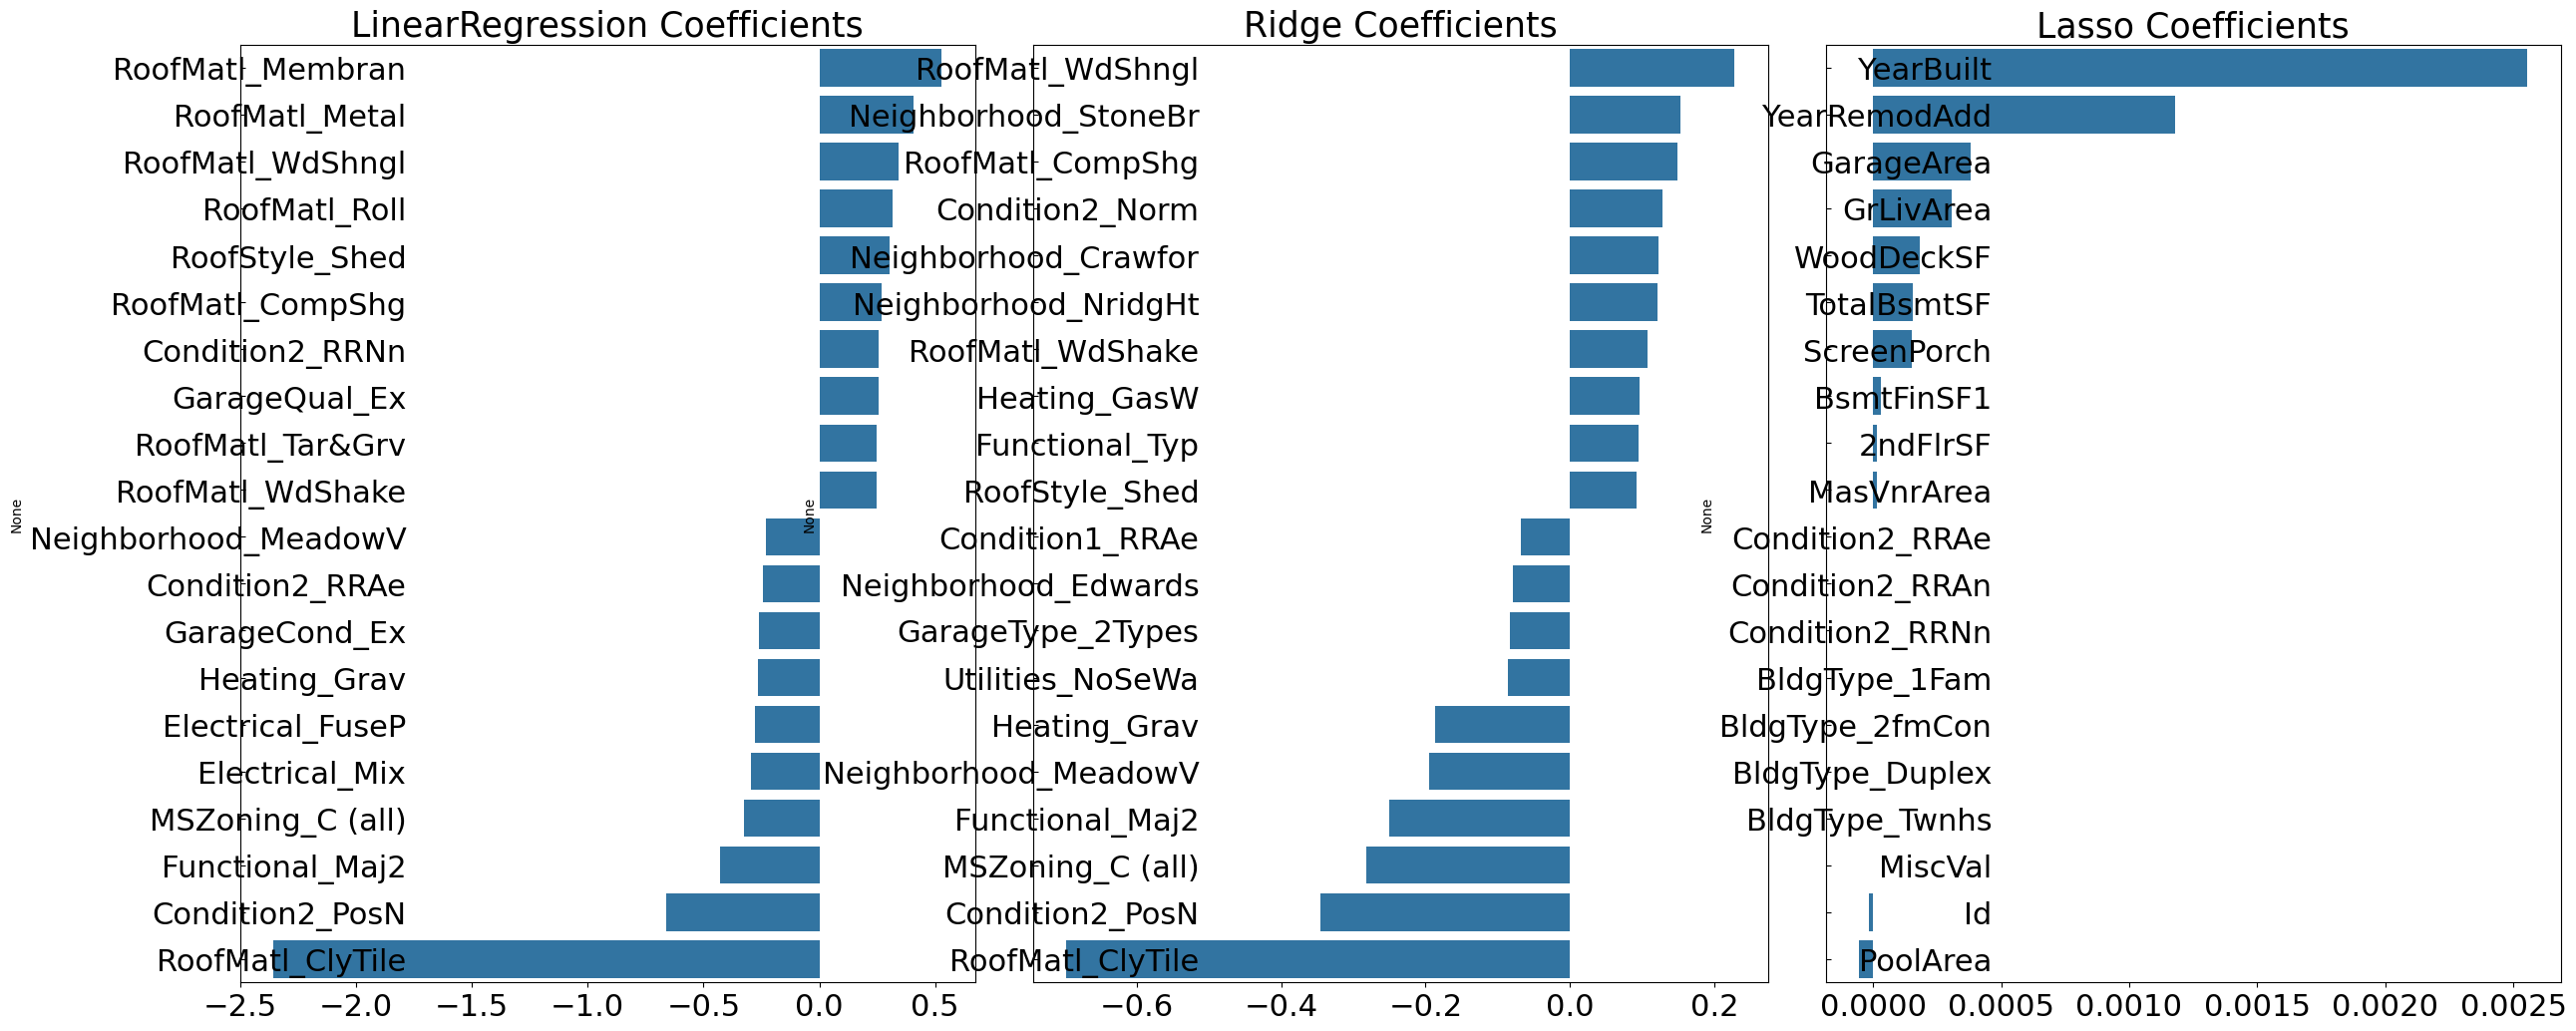

In [64]:
# 피처별 회귀계수 시각화

def get_top_bottom_coef(model, n=10):
    coef = pd.Series(model.coef_, index= X_features.columns)

    coef_high = coef.sort_values(ascending=False).head(n)
    coef_low = coef.sort_values(ascending= False).tail(n)
    
    return coef_high, coef_low



def visualize_coefficeint(models):
    fig, axs = plt.subplots(figsize=(24,10), nrows=1, ncols=3)
    fig.tight_layout()

    for i_num, model in enumerate(models):
        coef_high, coef_low = get_top_bottom_coef(model)
        coef_concat = pd.concat([coef_high, coef_low])

        axs[i_num].set_title(model.__class__.__name__ +' Coefficients', size=25)
        axs[i_num].tick_params(axis='y', direction='in', pad=-120)
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=coef_concat.values, y=coef_concat.index, ax=axs[i_num])

models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficeint(models)


- OLS 기반의 Linear Regression & Ridge => 회귀계수가 유사한 형태를 띔
- Lasso는 전체적으로 회귀계수가 작음. 그 중 YearBuild가 가장 크고, 다른 피처의 회귀 계수는 너무 작음.
  - 확인차, train, test dataset을 교차검증으로 분할하겠음.

In [65]:
from sklearn.model_selection import cross_val_score

def get_avg_rmse_cv(models):
    for model in models:
        rmse_list = np.sqrt(-cross_val_score(model, X_features, y_target, scoring='neg_mean_squared_error', cv=5))

        rmse_avg = np.mean(rmse_list)
        print(f'\n {model.__class__.__name__} CV RMSE 값 리스트: {rmse_list}')
        print(f'\n {model.__class__.__name__} CV 평균 RMSE 값: {np.round(rmse_avg,3)}')

models = [ridge_reg, lasso_reg]
get_avg_rmse_cv(models)


 Ridge CV RMSE 값 리스트: [0.11738091 0.15441547 0.14187826 0.11650402 0.18854432]

 Ridge CV 평균 RMSE 값: 0.144

 Lasso CV RMSE 값 리스트: [0.16060465 0.20427281 0.17693409 0.18117912 0.26512052]

 Lasso CV 평균 RMSE 값: 0.198


- cross_val_score로 총 5개 폴드로 학습한 후에도 여전히 라쏘 성능 < 릿지 성능
- 릿지, 라쏘 모델에 alpha값 조정하여 최적 값 도출해야 함

In [67]:
from sklearn.model_selection import GridSearchCV

def print_best_params(model, params):
    grid_model = GridSearchCV(model, param_grid= params,
                              scoring = 'neg_mean_squared_error',cv=5)
    
    grid_model.fit(X_features, y_target)
    rmse = np.sqrt(-1*grid_model.best_score_)
    print(f'{model.__class__.__name__} 5 CV 시 최적 평균 RMSE 값: {np.round(rmse,4)}, 최적 alpha: {grid_model.best_params_}')


ridge_param = {'alpha': [0.05, 0.1, 1, 5, 8,10,12,15,20]}
lasso_param = {'alpha': [0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10]}

print_best_params(ridge_reg, ridge_param)
print_best_params(lasso_reg, lasso_param)

Ridge 5 CV 시 최적 평균 RMSE 값: 0.1416, 최적 alpha: {'alpha': 10}
Lasso 5 CV 시 최적 평균 RMSE 값: 0.142, 최적 alpha: {'alpha': 0.001}


LinearRegression  로그변환된 RMSE:  0.133
Ridge  로그변환된 RMSE:  0.125
Lasso  로그변환된 RMSE:  0.121


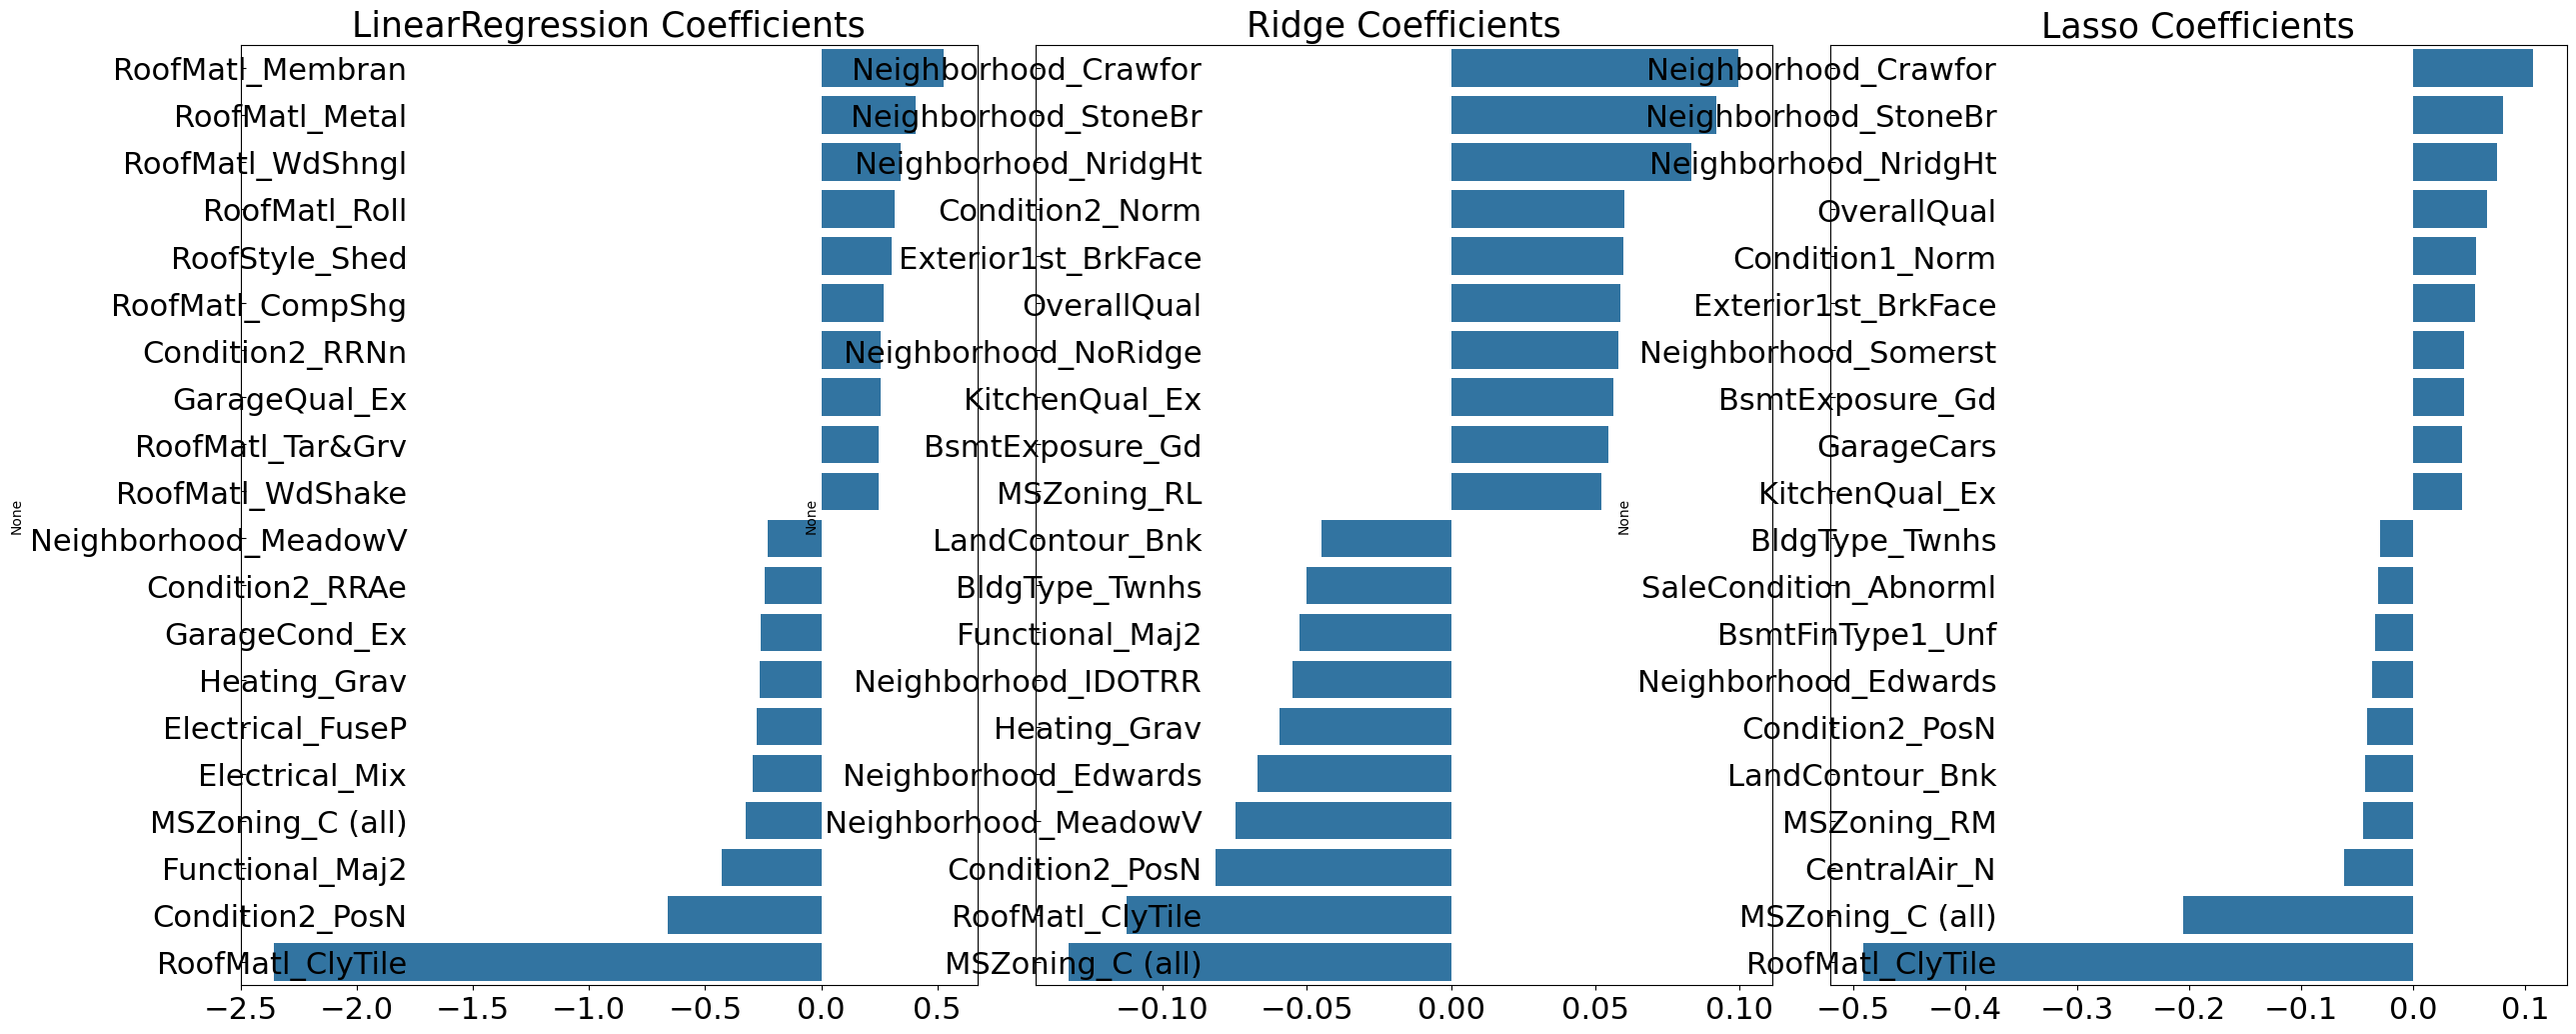

In [70]:
# 최적 파라미터 적용한 선형 모델

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)

ridge_reg = Ridge(alpha=10)
ridge_reg.fit(X_train, y_train)

lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)


models= [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)
visualize_coefficeint(models)

- alpha값 최적화 후, 테스트 데이터셋의 예측 성능이 더 좋아짐.
- 모델 별 회귀계수도 많이 달라짐.
  - Ridge와 Lasso의 회귀계수가 유사해짐.

# 데이터 추가 가공

In [80]:
# 왜도 확인 (왜도>1 인 데이터)

from scipy.stats import skew

# 숫자형 피처
featuers_index = house_df.dtypes[house_df.dtypes != 'object'].index
skew_features = house_df[featuers_index].apply(lambda x: skew(x))

# 왜도>1 피처
skew_features_top = skew_features[skew_features>1]
print(skew_features_top.sort_values(ascending=False))

MiscVal          24.451640
PoolArea         14.813135
LotArea          12.195142
3SsnPorch        10.293752
LowQualFinSF      9.002080
KitchenAbvGr      4.483784
BsmtFinSF2        4.250888
ScreenPorch       4.117977
BsmtHalfBath      4.099186
EnclosedPorch     3.086696
MasVnrArea        2.673661
LotFrontage       2.382499
OpenPorchSF       2.361912
BsmtFinSF1        1.683771
WoodDeckSF        1.539792
TotalBsmtSF       1.522688
MSSubClass        1.406210
1stFlrSF          1.375342
GrLivArea         1.365156
dtype: float64


In [87]:
# 왜도 높은 피처를 로그 변환
house_df[skew_features_top.index] = np.log1p(house_df[skew_features_top.index])

# 원핫 인코딩
house_df_ohe = pd.get_dummies(house_df)
y_target = house_df['SalePrice']
X_features = house_df.drop('SalePrice', axis=1, inplace = False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=.2, random_state=156)

print_best_params(ridge_reg, ridge_param)
print_best_params(lasso_reg, lasso_param)

ValueError: 
All the 45 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "c:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 1126, in fit
    X, y = self._validate_data(
  File "c:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py", line 584, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "c:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py", line 1106, in check_X_y
    X = check_array(
  File "c:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py", line 879, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
  File "c:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\_array_api.py", line 185, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
  File "C:\Users\TEMP\AppData\Roaming\Python\Python39\site-packages\pandas\core\generic.py", line 1993, in __array__
    return np.asarray(self._values, dtype=dtype)
ValueError: could not convert string to float: 'RL'


In [89]:
ridge_param

{'alpha': [0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]}